# 3 - Exploratory Data Analysis

**Author:** M. Görkem Ulutürk

**Date:** February, 2026

## Introduction

Previously, we've imported, cleaned, and validated the data, then imputed the
missing values. Here's a quick reminder: We've

- Converted column names to lowercase
- Validated data types of columns
- Validated the data except for columns such as `fare` and `name`, where it is
not possible to do so
- Extracted a new column `title` from the passenger names, denoting the
honorifics such as Mr. and Mrs.
- Extracted a new column `deck` from the cabin numbers, such as deck "A" from
cabin "A67"
- Extracted a new column `fare_per_passenger` using `ticket`, `sibsp`,
`parch` columns
- Using the `title` column, we've validated the `sex` column
- Using the `title` column and basic statistical tools, we've imputed missing
`age` values
- Imputed 2 missing `embarked` entries using mode
- Imputed 687 missing `cabin` values (77.1% of the whole data) using a random
forest model, trained on `fare_per_passenger` and `pclass` columns

In this section, our goal is to answer some questions, discover insights, and
prepare ourselves for the model-building phase. Firstly, let's recall our goal.

**Goal**: We want to understand what factors, if there's any, contributes to
a passenger's survival.

Questions we'll be answering throughout this notebook can be summarized as:

- What variables are correlated with `survived`?
- Are there hierarchies within features affecting survivorship? For example,
children versus middle-aged survivorship.
- Are there correlated features?

As usual, we'll start with the imports.

## Imports

We'll import the raw data as well. The purpose is to obtain the passenger IDs
for certain cases. For example, we want to get the IDs of passengers with
missing age values so that our deductions are minimally affected by
possible noise we introduced with data imputation. We will explore the
modified data as well, but it's a good idea to keep the original and even
compare the two.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
na_age_idx = pd.read_csv("../data/raw/na_ids.csv", index_col=0)

na_age_idx.head(10)

,passengerid
5,6
17,18
19,20
26,27
28,29
29,30
31,32
32,33
36,37
42,43


In [3]:
df = pd.read_csv("../data/modified/cleaned.csv")

df.head(10)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,deck,title,fare_per_person
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G,Mr.,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs.,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,E,Miss.,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs.,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,E,Mr.,8.05000
5,6,0,3,"Moran, Mr. James",male,26.0,0,0,330877,8.4583,NaN,Q,E,Mr.,8.45830
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,E,Mr.,51.86250
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,G,Master.,4.21500
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,G,Mrs.,3.71110
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,D,Mrs.,15.03540


Let's remind ourselves of the data structure.

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passengerid      891 non-null    int64  
 1   survived         891 non-null    int64  
 2   pclass           891 non-null    int64  
 3   name             891 non-null    str    
 4   sex              891 non-null    str    
 5   age              891 non-null    float64
 6   sibsp            891 non-null    int64  
 7   parch            891 non-null    int64  
 8   ticket           891 non-null    str    
 9   fare             891 non-null    float64
 10  cabin            204 non-null    str    
 11  embarked         891 non-null    str    
 12  deck             891 non-null    str    
 13  title            891 non-null    str    
 14  fare_per_person  891 non-null    float64
dtypes: float64(3), int64(5), str(7)
memory usage: 104.5 KB


## Univariate Data Analysis

We'll first setup the Seaborn configuration.

In [5]:
sns.set_theme(
    style="whitegrid",
    palette="muted",
    rc={
        "axes.spines.left": True,
        "axes.spines.top": False,
        "axes.spines.right": False,
    },
)

We'll also define some helper functions.

In [6]:
def describe_numeric(data: pd.DataFrame, column: str | list[str]):
    """Custom defined descriptive statistics generator for numeric data."""
    return data[column].agg(
        count="count",
        mean="mean",
        median="median",
        std="std",
        min="min",
        q25=lambda x: x.quantile(0.25),
        q50=lambda x: x.quantile(0.50),
        q75=lambda x: x.quantile(0.75),
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25),
        max="max",
        skew="skew",
    )

def describe_categorical(data: pd.DataFrame, column: str | list[str]):
    """Custom define descriptive statistics generator for categorical data."""
    return pd.concat(
        {
            "Count": data[column].value_counts(),
            "Percentage": data[column].value_counts(normalize=True)*100
        },
        axis = 1
    )

def first_nonzero_percentile(data: pd.DataFrame, column: str):
    """Returns the first nonzero percentile for the specified column"""
    return (data[column] == 0).mean()

### Survived

`survived` is the binary target variable.

In [7]:
describe_categorical(df, "survived")

,Count,Percentage
survived,,
0,549,61.616162
1,342,38.383838


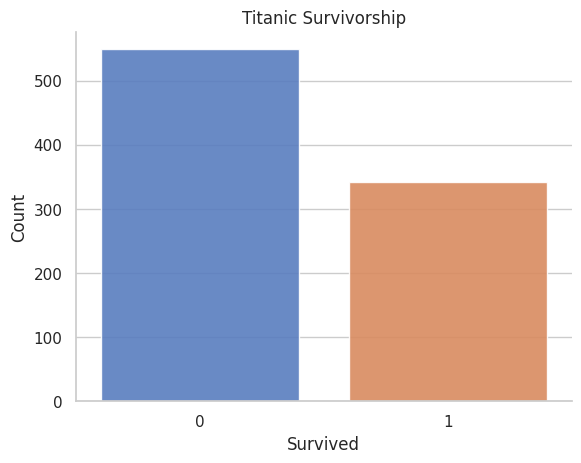

In [8]:
ax = sns.countplot(
    data=df, x="survived", hue="survived", alpha=0.9, legend=False
)

ax.set_xlabel("Survived")
ax.set_ylabel("Count")
ax.set_title("Titanic Survivorship")

plt.savefig("../assets/survived_dist.png")
plt.show()

**Remarks**

- 342 passengers survived
- 549 passengers did not survive

Titanic's sinking resulted in approximately 1500 deaths among roughly 2200
passengers, which makes the survival rate about 31.8%. In our training
dataset, this rate is about 38.4%.

### Numeric Features

Numeric features in the dataset are as follows:

- `sibsp`: The number of siblings/spouses aboard the Titanic
- `parch`: The number of parents/children aboard the Titanic
- `fare`: Passenger fare
- `age`: Age in years

We also feature extracted the `fare_per_person` column.

#### Sibsp

In [9]:
describe_numeric(df, "sibsp")

count     891.000000
mean        0.523008
median      0.000000
std         1.102743
min         0.000000
q25         0.000000
q50         0.000000
q75         1.000000
iqr         1.000000
max         8.000000
skew        3.695352
Name: sibsp, dtype: float64

In [10]:
first_nonzero_percentile(df, "sibsp")

np.float64(0.6823793490460157)

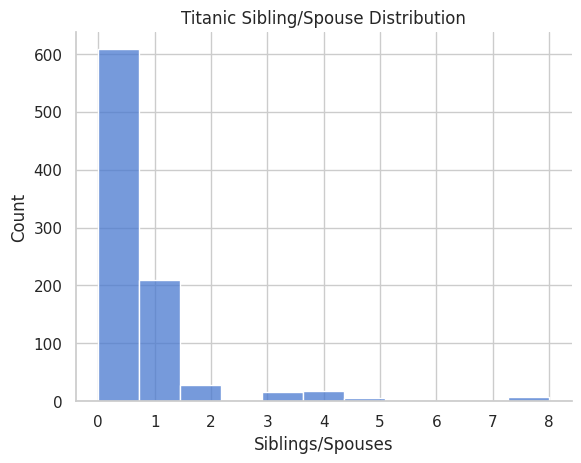

In [11]:
ax = sns.histplot(data=df, x="sibsp", bins=list(range(0, 9)), binwidth=0.75)

ax.set_xlabel("Siblings/Spouses")
ax.set_title("Titanic Sibling/Spouse Distribution")

plt.savefig("../assets/sibsp_dist.png")
plt.show()

**Remarks**

- 8 siblings is the maximum in our training data
- Mean sibling/spouse count is 0.52 with median 0
- A skew value of 3.7 indicates a strong positive skew
- 68.2% of the passengers have no siblings/spouses aboard
- In summary, `sibsp` is dominated by passengers with no siblings or spouses,
resulting in a highly right-skewed distribution

#### Parch

In [12]:
describe_numeric(df, "parch")

count     891.000000
mean        0.381594
median      0.000000
std         0.806057
min         0.000000
q25         0.000000
q50         0.000000
q75         0.000000
iqr         0.000000
max         6.000000
skew        2.749117
Name: parch, dtype: float64

In [13]:
first_nonzero_percentile(df, "parch")

np.float64(0.7609427609427609)

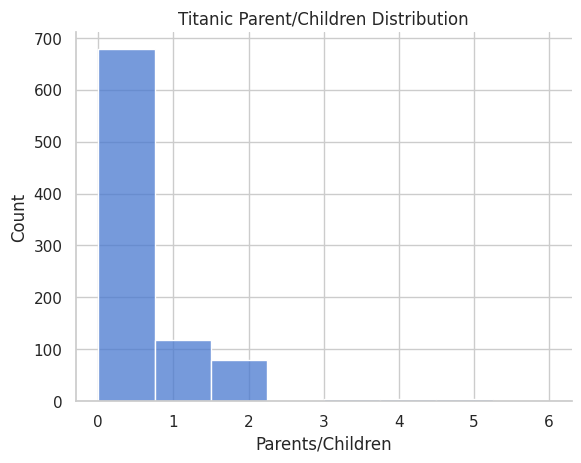

In [14]:
ax = sns.histplot(data=df, x="parch", bins=list(range(0, 7)), binwidth=0.75)

ax.set_xlabel("Parents/Children")
ax.set_title("Titanic Parent/Children Distribution")

plt.savefig("../assets/parch_dist.png")
plt.show()

**Remarks**

- 6 children is the maximum in our training data
- Mean parents/children count is 0.38 with median 0
- A skew value of 2.7 indicates a strong positive skew
- 76.1% of the passengers have no parents/children aboard
- In summary, `parch` is dominated by passengers with no parents/children,
resulting in a highly right-skewed distribution

**Takeaways**

We'll investigate these two features more in-depth in the multivariate data
analysis section. However, we can draw some conclusions by combining our
results.

- Since both `sibsp` and `parch` are highly right-skewed, and most passengers
had no siblings/spouses or parents/children, 68% and 76% respectively, we can
safely conclude that most passengers traveled without close family members.
- The mean of `sibsp` being greater than `parch`, 0.52 versus 0.38,
suggesting that there were siblings traveling without their parents or
couples without any children. The latter is more plausible in this context.

Note that we do not declare a passenger with `sibsp == 0 & parch == 0` as
someone who traveled alone. It simply means they did not travel with close
family members. In fact, it was quite common among first-class passengers to
travel with maids or assistants.

#### Age

Before we start our analysis, let's define the age groups we'll use. We will
stick to these definitions throughout the project.

Age Interval | Class
-------------|------
<1 Years     | Infant
1-12 Years   | Child
13-18 Years  | Youth
19-24 Years  | Young Adult
25-44 Years  | Adult
45-64 Years  | Middle Aged
65+          | Aged

**NOTE:** We did not have any cultural, socioeconomic, or other
considerations to make this classification. It's purely for interpretation
purposes. If such a grouping is needed for statistical inference or model
building, we'll make the distinctions in a more concrete way. For our
purposes, these should serve as a decent guideline. Additionally, the fact
that we're set to develop a tree based model, making such virtual
distinctions could affect model performance in a negative way.

Recall that we've imputed missing values in this column. We'll first analyze
the raw age data.

In [15]:
raw_age = df.loc[~df.passengerid.isin(na_age_idx)]

describe_numeric(raw_age, "age")

count     891.000000
mean       28.999630
median     26.000000
std        13.655960
min         0.420000
q25        21.000000
q50        26.000000
q75        36.750000
iqr        15.750000
max        80.000000
skew        0.450187
Name: age, dtype: float64

**Remarks**

 - Youngest passenger is 0.42 years old while the oldest passenger is 80.
     - Recall from the data dictionary that if a passenger's `age < 1`,
     then the age is expressed as a fraction. In this case, the said
     passenger is roughly 22 weeks old.
 - Median age of 28 is very close to the mean age of 29.7.
 - A standard deviation of 14.5 indicates that the age feature is quite
 spread.
 - About half the passengers are young adults and adults.
     - We'll analyze the age groups separately.

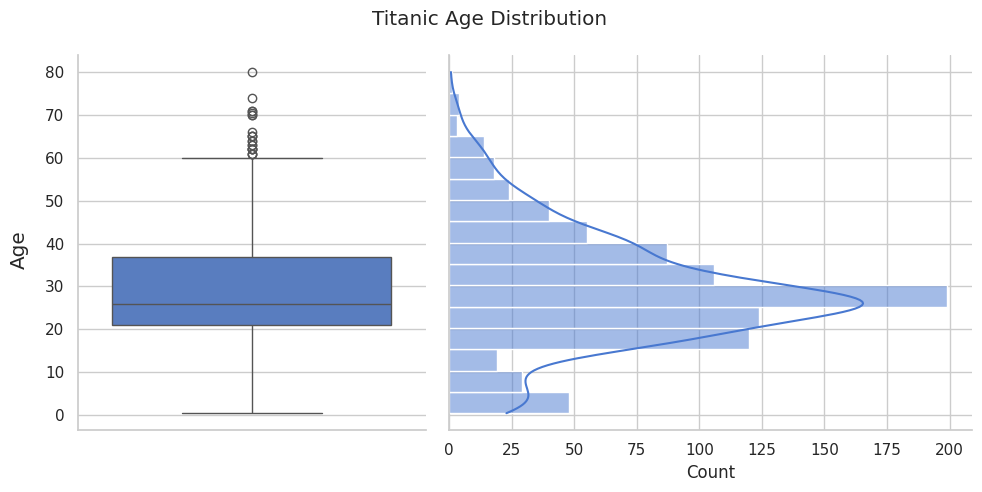

In [16]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharey=True, gridspec_kw={"width_ratios": [0.4, 0.6]}
)
fig.set_figheight(5)
fig.set_figwidth(10)

sns.boxplot(data=raw_age, y="age", ax=axes[0])
sns.histplot(data=raw_age, y="age", binwidth=5, kde=True, ax=axes[1])

axes[0].set(ylabel=None)
fig.supylabel("Age")
fig.suptitle("Titanic Age Distribution")

plt.tight_layout()
plt.savefig("../assets/age_dist.png")
plt.show()

**Remarks**

- Data is approximately symmetric about the median with a slight positive
skew.
- Data is unimodal.
- There are several high-age outliers above age ~65.
    - These statistical outliers are most likely genuine data rather than
    error based on historical facts.
- There are no outliers on the lower-end, left tail is less extreme
relative to the IQR.
- IQR is roughly between 20 and 40 years, which falls into the young
adult & adult age groups.

Let's also compare imputed age values with raw age data.

In [17]:
pd.concat(
    {
        "raw": describe_numeric(raw_age, "age"),
        "modified": describe_numeric(df, "age"),
    },
    axis=1,
)

,raw,modified
count,891.000000,891.000000
mean,28.999630,28.999630
median,26.000000,26.000000
std,13.655960,13.655960
min,0.420000,0.420000
q25,21.000000,21.000000
q50,26.000000,26.000000
q75,36.750000,36.750000
iqr,15.750000,15.750000
max,80.000000,80.000000


Recall that we've imputed the age feature as follows:

- We used `title` feature we've extracted from the `name` column for age
imputation
- For missing age entries with titles Dr. and Master., we've used their group
median  ages
- For the title Miss., we've used `parch` column to differentiate young girls
from unmarried adult women and filled the missing values by taking the median
age
- For the rest of the missing data, we've assigned medians based on `pclass`
and `title`

By looking at the table, we can understand the following:

- Entry count increased from 714 to 891
- Mean age decreased about 2.36% while the median age decreased about 7.14%
- Standard deviation also decreased
- Since we've used median ages for imputation, the minimum and maximum ages
remained the same
- Skewness increased by 15.7%

One important note here is that none of these changes are extreme. For one
thing, imputed values did not drastically change any descriptive statistic.
Given we've imputed about 20% of the whole data, the noise introduced seems
minimal from what we can tell. Let's also compare the distributions.

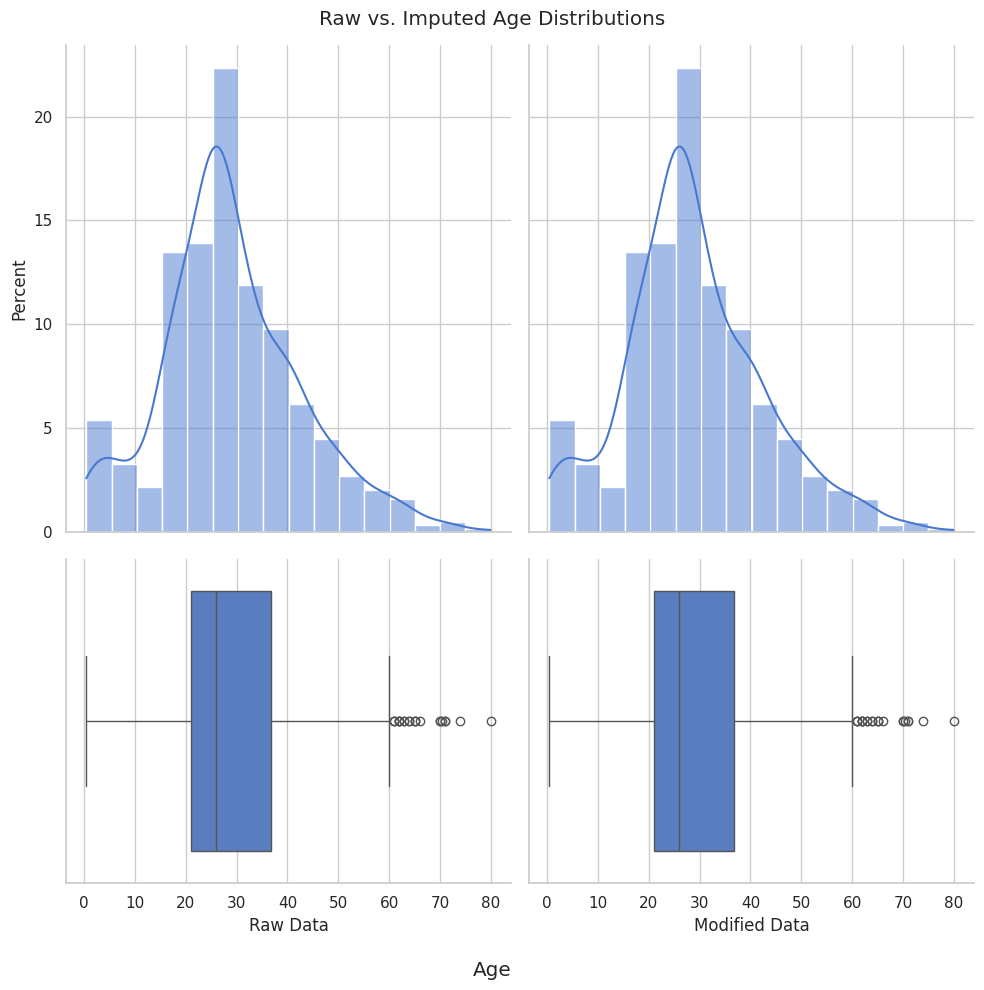

In [18]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex="col",
    sharey="row",
    gridspec_kw={"height_ratios": [0.6, 0.4]},
)
fig.set_figheight(10)
fig.set_figwidth(10)

axes[1, 0].set(xlabel="Raw Data")
axes[1, 1].set(xlabel="Modified Data")
fig.supxlabel("Age")
fig.suptitle("Raw vs. Imputed Age Distributions")

sns.histplot(
    data=raw_age, x="age", binwidth=5, kde=True, ax=axes[0, 0], stat="percent"
)
sns.histplot(
    data=df, x="age", binwidth=5, kde=True, ax=axes[0, 1], stat="percent"
)
sns.boxplot(data=raw_age, x="age", ax=axes[1, 0])
sns.boxplot(data=df, x="age", ax=axes[1, 1])

plt.tight_layout()
plt.savefig("../assets/raw_vs_imputed_age_comparison.png")
plt.show()

Distributions look similar except around the median. Since we've imputed the
majority of the missing values with the median, imputed age distribution has
steeper median value. On the other hand, rest of the distribution seems
similar and looks as expected from an age distribution in our case. It still
captures  the characteristic that the age distribution is positively skewed.
One other change we can observe is the number of statistical outliers, which
is as expected since the mean and the standard deviation are lower in
modified data.

Now, let's also plot the age groups we defined earlier.

     age group  count  percentage
0        Adult    482   54.096521
1  Young Adult    134   15.039282
2  Middle Aged    112   12.570146
3        Child     74    8.305275
4        Youth     69    7.744108
5         Aged     13    1.459035
6       Infant      7    0.785634


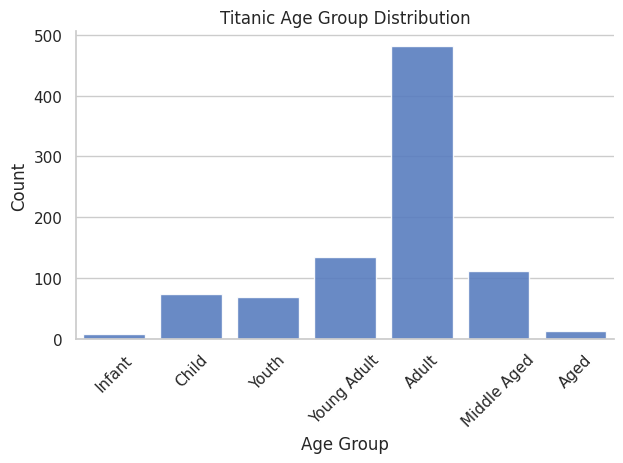

In [19]:
age_groups = pd.cut(
    df["age"],
    bins = [0, 1, 12, 18, 24, 44, 64, 100],
    labels = ["Infant", "Child", "Youth", "Young Adult", "Adult",
              "Middle Aged", "Aged"],
    right = False,
    include_lowest = True
)
if isinstance(age_groups, pd.Series):
    counts = age_groups.value_counts()
    percentages = age_groups.value_counts(normalize=True) * 100

    age_groups = pd.DataFrame({
        "age group": counts.index,
        "count": counts.values,
        "percentage": percentages.values
    })

    age_groups = (
        age_groups.sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

else:
    raise ValueError()

print(age_groups)

ax = sns.barplot(
    data=age_groups, x="age group", y="count", alpha=0.9, legend=False
)

plt.xticks(rotation = 45)

ax.set_xlabel("Age Group")
ax.set_ylabel("Count")
ax.set_title("Titanic Age Group Distribution")

plt.tight_layout()
plt.savefig("../assets/age_group_dist.png")
plt.show()

#### Fare

In [20]:
print(df.fare.mean())
df.sort_values(by="fare", ascending=False)["fare"].head(21)

32.204207968574636


679    512.3292
258    512.3292
737    512.3292
88     263.0000
438    263.0000
341    263.0000
27     263.0000
742    262.3750
311    262.3750
299    247.5208
118    247.5208
700    227.5250
716    227.5250
380    227.5250
557    227.5250
527    221.7792
377    211.5000
779    211.3375
730    211.3375
689    211.3375
318    164.8667
Name: fare, dtype: float64

`fare` column's mean is 32.2 while the maximum value is 512.3292. Therefore,
plotting without filtering make the visual not easily readable. Hence, we'll
filter the maximum values for the graph.

In [21]:
fare_desc = describe_numeric(df, "fare")
print(fare_desc)

count     891.000000
mean       32.204208
median     14.454200
std        49.693429
min         0.000000
q25         7.910400
q50        14.454200
q75        31.000000
iqr        23.089600
max       512.329200
skew        4.787317
Name: fare, dtype: float64


**Remarks**

- The minimum fare is GBP 0 while the highest fare is GBP 512.
   - Highest fare is historically accurate in this case.
- Median fare is GBP 14.5 while the mean is 32.2.
- The standard deviation is GBP 49.7, which is quite high, especially
compareed to the mean. Thus, the data is quite spread out.
- About half the passengers paid GBP 14.5 or less, 25% of which paid about
GBP 7.9 or less.
- About 25% of the passengers paid more than GBP 31.

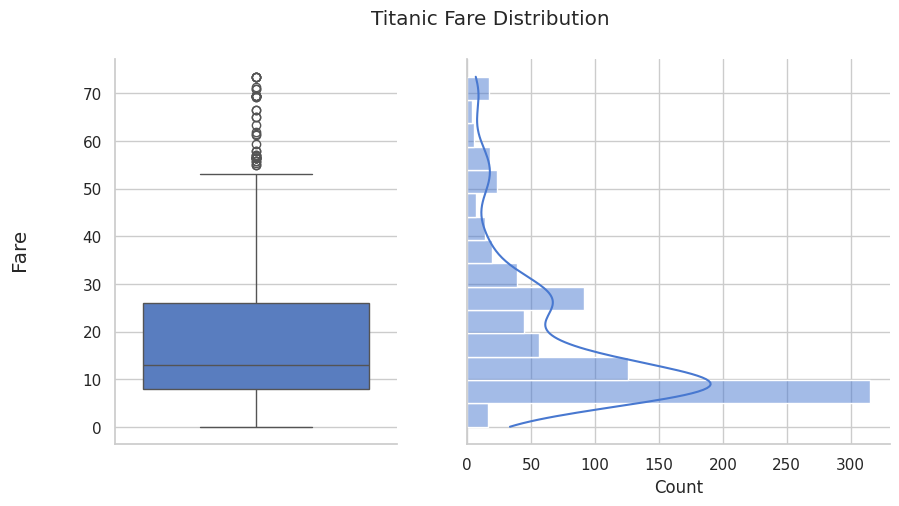

In [22]:
fare_filtered = df.loc[df.fare <= 75]
fig, axes = plt.subplots(
    nrows=1, ncols=2, sharey=True, gridspec_kw={"width_ratios": [0.4, 0.6]}
)
fig.set_figheight(5)
fig.set_figwidth(10)

sns.boxplot(data=fare_filtered, y="fare", ax=axes[0])
sns.histplot(data=fare_filtered, y="fare", binwidth=5, kde=True, ax=axes[1])

axes[0].set(ylabel=None)
fig.supylabel("Fare")
fig.suptitle("Titanic Fare Distribution")

plt.savefig("../assets/fare_dist.png")
plt.show()

**Remarks**

- Data is extremely skewed. A skew value of 4.79 indicates an extreme
positive skew.
- There are a lot of statistical outliers above ~GBP 60.
   - In fact, there are 20 outliers detected by the z-test, or 116
   outliers detected using IQR.
   - However, note that these statistical outliers are highly likely to be
   legitimate values. In reality, the Titanic had luxurious suites with
   very high markups. For example, the highest value of GBP 512 is
   historically accurate.
 - There are no outliers on the lower-end, left tail is less extreme
 relative to the IQR.
 - IQR is about GBP 23.1

Below is the IQR and z-scores tests for outliers.

In [23]:
iqr = fare_desc["iqr"]
q3 = fare_desc["q75"]
upper_lim = q3 + 1.5 * iqr

print(f"Outlier count using IQR: {df[df.fare > upper_lim].shape[0]}")

z_scores = np.asarray(stats.zscore(df["fare"]))

print(f"Outlier count using z-scores: {np.count_nonzero(z_scores > 3)}")

Outlier count using IQR: 116
Outlier count using z-scores: 20


Let's also plot log-scaled `fare`.

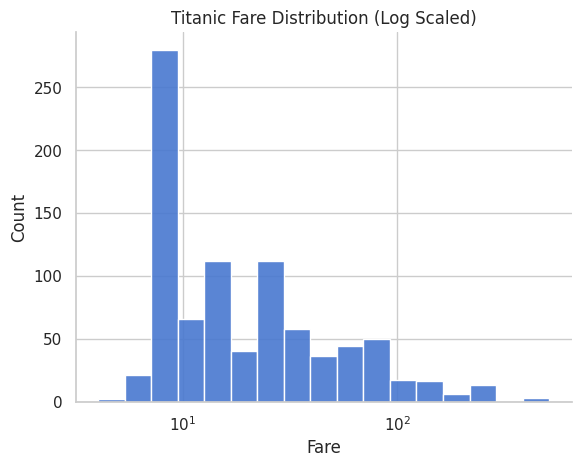

In [24]:
ax = sns.histplot(
    data=df, x="fare", alpha=0.9, legend=False, log_scale=True
)

ax.set_xlabel("Fare")
ax.set_ylabel("Count")
ax.set_title("Titanic Fare Distribution (Log Scaled)")

plt.savefig("../assets/fare_logscaled_dist.png")
plt.show()

### Categorical Features

Categorical features in the dataset are as follows:

- `pclass`
- `name`
- `sex`
- `ticket`
- `cabin`
- `embarked`: Port of embarkation

We've also feature extracted

- `deck`
- `title`

We will not analyze the `name`, `ticket`, and `cabin` columns.

#### PClass

In [25]:
describe_categorical(df, "pclass")

,Count,Percentage
pclass,,
3,491,55.106622
1,216,24.242424
2,184,20.650954


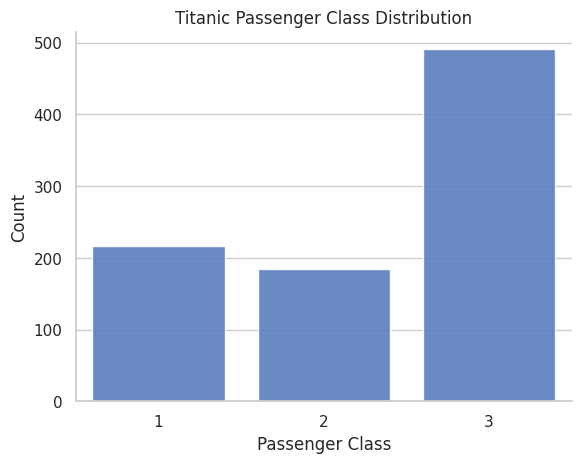

In [26]:
ax = sns.countplot(
    data=df, x="pclass", alpha=0.9, legend=False
)

ax.set_xlabel("Passenger Class")
ax.set_ylabel("Count")
ax.set_title("Titanic Passenger Class Distribution")

plt.savefig("../assets/pclass_dist.png")
plt.show()

**Remarks**

- More than half of the passengers were third-class
- There are more first-class passengers than second-class

#### Sex

In [27]:
describe_categorical(df, "sex")

,Count,Percentage
sex,,
male,577,64.758698
female,314,35.241302


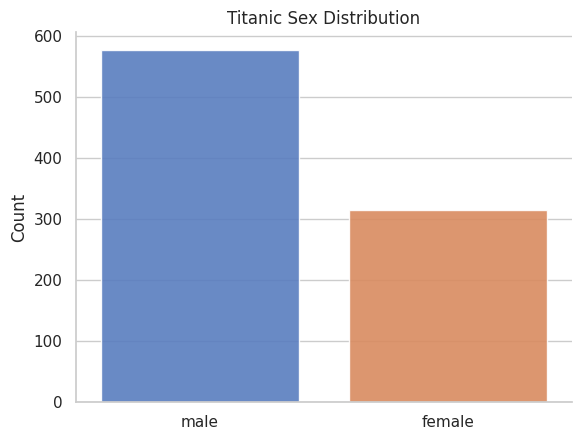

In [28]:
ax = sns.countplot(
    data=df, x="sex", hue="sex", alpha=0.9, legend=False
)

ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_title("Titanic Sex Distribution")

plt.savefig("../assets/sex_dist.png")
plt.show()

**Remarks**

- Out of 891 passengers, 577 of the are male, 64.8% of the passengers, while
314 are female

#### Embarked

In [29]:
describe_categorical(df, "embarked")

,Count,Percentage
embarked,,
S,646,72.502806
C,168,18.855219
Q,77,8.641975


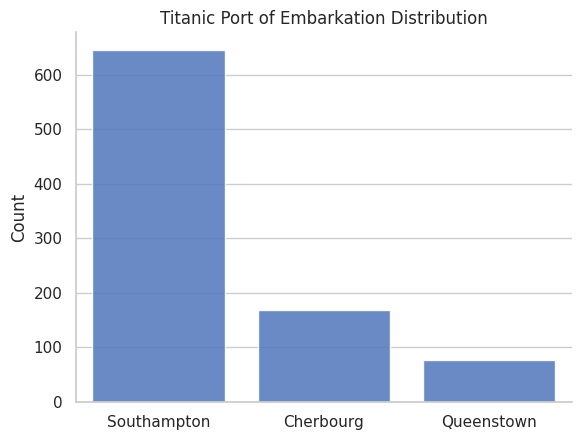

In [30]:
ax = sns.countplot(
    data=df, x="embarked", alpha=0.9, legend=False
)

plt.xticks([0, 1, 2], ["Southampton", "Cherbourg", "Queenstown"])

ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_title("Titanic Port of Embarkation Distribution")

plt.savefig("../assets/embarked_dist.png")
plt.show()

**Remarks**

- 72.5% of the passengers embarked from Southampton, England
- 18.9% of the passengers embarked from Cherbourg, France
- 8.64% of the passengers embarked from Queenstown, Ireland

#### Deck

Recall that we've extracted the deck feature from the `cabin` column, then
imputed the missing values. About 77% of the `deck` data was missing prior to
imputation.

In [31]:
describe_categorical(df, "deck")

,Count,Percentage
deck,,
F,272,30.527497
E,248,27.833895
D,118,13.243547
G,100,11.223345
C,82,9.203143
B,55,6.172840
A,15,1.683502
T,1,0.112233


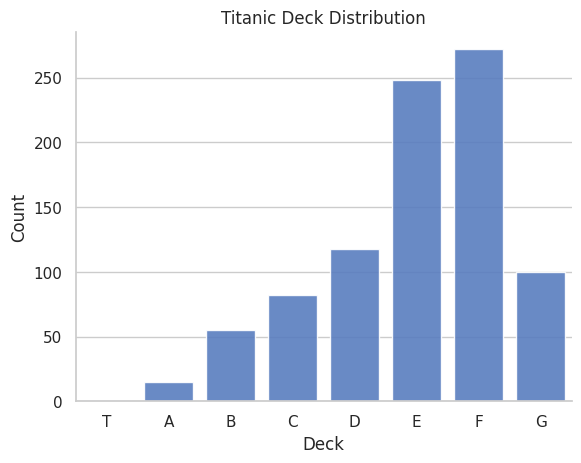

In [32]:
ax = sns.countplot(
    data=df,
    x="deck",
    alpha=0.9,
    legend=False,
    order = ["T", "A", "B", "C", "D", "E", "F", "G"]
)

ax.set_xlabel("Deck")
ax.set_ylabel("Count")
ax.set_title("Titanic Deck Distribution")

plt.savefig("../assets/deck_dist.png")
plt.show()

**Remarks**

- The majority of the passengers occupied E & F decks
- Deck T had only 1 passenger
  - Recall that we've validated the data already, there's no mistake here
- Data is negatively skewed
- Mode of deck is deck F

#### Title

Recall that we've extracted the title feature from the `name` column.

In [33]:
describe_categorical(df, "title")

,Count,Percentage
title,,
Mr.,517,58.024691
Miss.,182,20.426487
Mrs.,125,14.029181
Master.,40,4.489338
Dr.,7,0.785634
Rev.,6,0.673401
Major.,2,0.224467
Mlle.,2,0.224467
Col.,2,0.224467


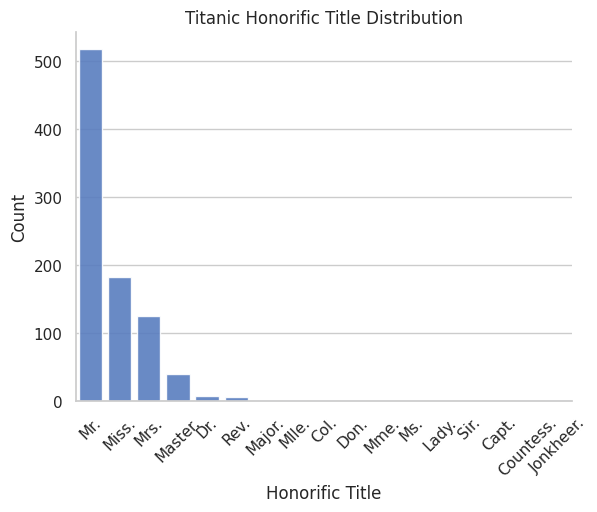

In [34]:
ax = sns.countplot(
    data=df,
    x="title",
    alpha=0.9,
    legend=False,
    order = df["title"].value_counts().sort_values(ascending=False).index
)

plt.xticks(rotation=45)

ax.set_xlabel("Honorific Title")
ax.set_ylabel("Count")
ax.set_title("Titanic Honorific Title Distribution")

plt.show()

This plot isn't exactly easy to read. Let's group titles with 1 or 2
occurrences into a combined group called *"Others"* and plot again.

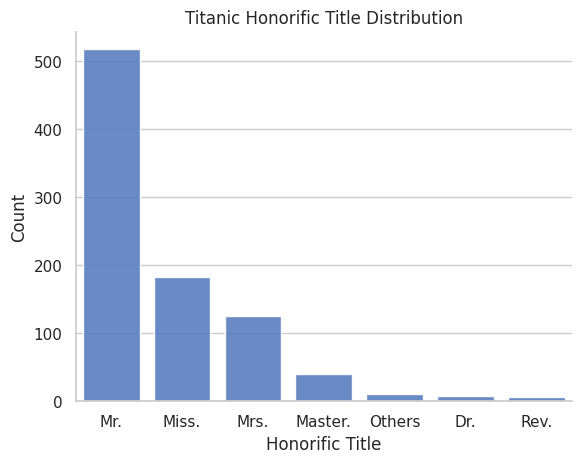

In [35]:
titles_df = df["title"].value_counts().reset_index()
titles_df.columns = ["title", "count"]
titles_df.loc[-1] = ["Others", sum(titles_df["count"]<=2)]
titles_df = (
    titles_df.drop(titles_df[titles_df["count"] <= 2].index)
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)

ax = sns.barplot(
    data=titles_df, x="title", y="count", alpha=0.9, legend=False,
)

ax.set_xlabel("Honorific Title")
ax.set_ylabel("Count")
ax.set_title("Titanic Honorific Title Distribution")

plt.savefig("../assets/title_dist.png")
plt.show()

**Remarks**

- More than half the passengers, 58% to be precise, were Mr.
- Occupation related titles, such as Dr. or Col., are rare
- Majority of the passengers had English honorifics but there were also some
honorifics in French, Italian, etc.